<a href="https://colab.research.google.com/github/FelixH-git/SVM-Pipeline/blob/main/labb6.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import os
import tarfile
import urllib.request

DOWNLOAD_ROOT = "https://raw.githubusercontent.com/ageron/handson-ml2/master/"
HOUSING_PATH = os.path.join("datasets", "housing")
HOUSING_URL = DOWNLOAD_ROOT + "datasets/housing/housing.tgz"

def fetch_housing_data(housing_url=HOUSING_URL, housing_path=HOUSING_PATH):
    if not os.path.isdir(housing_path):
        os.makedirs(housing_path)
    tgz_path = os.path.join(housing_path, "housing.tgz")
    urllib.request.urlretrieve(housing_url, tgz_path)
    housing_tgz = tarfile.open(tgz_path)
    housing_tgz.extractall(path=housing_path)
    housing_tgz.close()

In [2]:
fetch_housing_data()


In [3]:
import pandas as pd

def load_housing_data(housing_path=HOUSING_PATH):
    csv_path = os.path.join(housing_path, "housing.csv")
    return pd.read_csv(csv_path)

In [4]:
housing = load_housing_data()
housing.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


In [5]:
from sklearn.model_selection import train_test_split

train_set, test_set = train_test_split(housing, test_size=0.2, random_state=42)

In [6]:
X = train_set[["longitude", "latitude", "median_income"]]

X.info()

<class 'pandas.core.frame.DataFrame'>
Index: 16512 entries, 14196 to 15795
Data columns (total 3 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   longitude      16512 non-null  float64
 1   latitude       16512 non-null  float64
 2   median_income  16512 non-null  float64
dtypes: float64(3)
memory usage: 516.0 KB


In [7]:
Y = train_set["median_house_value"]

In [8]:
from sklearn.cluster import KMeans


# Create the KMeans model
kmeans = KMeans(n_clusters=5, random_state=42)

# Fit the model to the data
kmeans.fit(X)



KMeans(n_clusters=5, random_state=42)

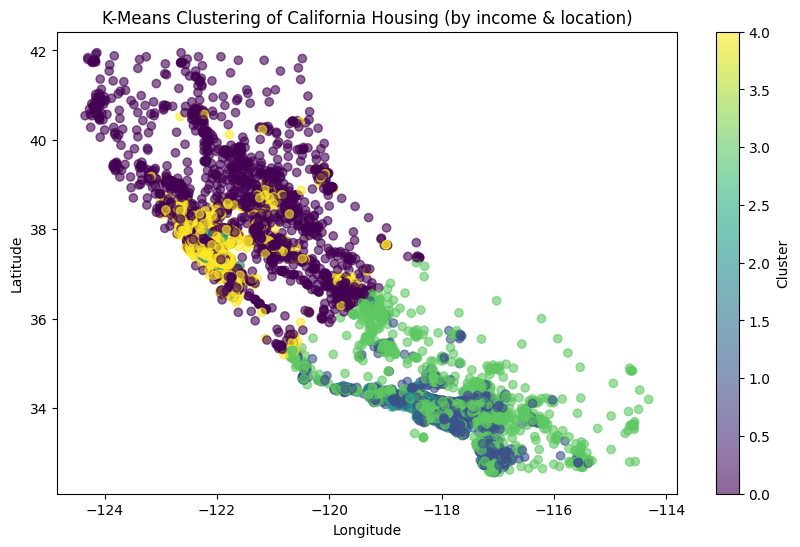

In [9]:
import matplotlib.pyplot as plt


# Add the cluster labels to the dataset
train_set["cluster"] = kmeans.labels_

# Visualize
plt.figure(figsize=(10,6))
plt.scatter(train_set["longitude"], train_set["latitude"],
            c=train_set["cluster"], cmap="viridis", alpha=0.6)
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.title("K-Means Clustering of California Housing (by income & location)")
plt.colorbar(label="Cluster")
plt.show()


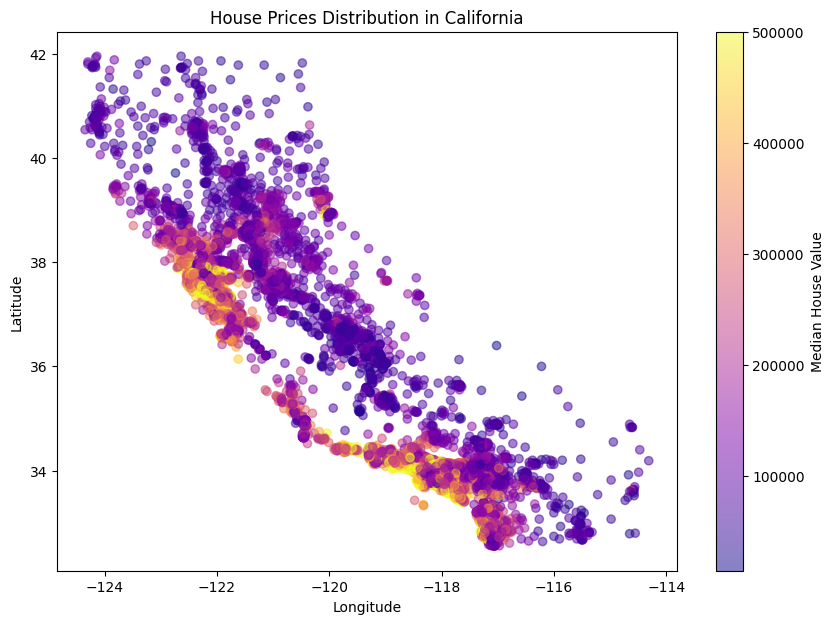

In [10]:
plt.figure(figsize=(10, 7))
plt.scatter(train_set["longitude"], train_set["latitude"],
            c=train_set["median_house_value"], cmap="plasma", alpha=0.5)
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.title("House Prices Distribution in California")
plt.colorbar(label="Median House Value")
plt.show()

In [11]:
train_set.head(10)

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity,cluster
14196,-117.03,32.71,33.0,3126.0,627.0,2300.0,623.0,3.2596,103000.0,NEAR OCEAN,3
8267,-118.16,33.77,49.0,3382.0,787.0,1314.0,756.0,3.8125,382100.0,NEAR OCEAN,3
17445,-120.48,34.66,4.0,1897.0,331.0,915.0,336.0,4.1563,172600.0,NEAR OCEAN,1
14265,-117.11,32.69,36.0,1421.0,367.0,1418.0,355.0,1.9425,93400.0,NEAR OCEAN,3
2271,-119.80,36.78,43.0,2382.0,431.0,874.0,380.0,3.5542,96500.0,INLAND,0
17848,-121.86,37.42,20.0,5032.0,808.0,2695.0,801.0,6.6227,264800.0,<1H OCEAN,4
6252,-117.97,34.04,28.0,1686.0,417.0,1355.0,388.0,2.5192,157300.0,<1H OCEAN,3
9389,-122.53,37.91,37.0,2524.0,398.0,999.0,417.0,7.9892,500001.0,NEAR BAY,4
6113,-117.90,34.13,5.0,1126.0,316.0,819.0,311.0,1.5000,139800.0,<1H OCEAN,3
6061,-117.79,34.02,5.0,18690.0,2862.0,9427.0,2777.0,6.4266,315600.0,<1H OCEAN,1


In [12]:
cluster_price_summary = train_set.groupby("cluster")["median_house_value"].mean().sort_values()
print(cluster_price_summary)

cluster
0    145186.103262
3    165040.829795
1    265944.331475
4    282187.329309
2    463079.114165
Name: median_house_value, dtype: float64


In [13]:
kmeans.inertia_

37996.689490723365

In [14]:
from sklearn.metrics import silhouette_score

silhouette_score(X, kmeans.labels_)

np.float64(0.37535704647264845)

In [ ]:
kmeans_per_k = [KMeans(n_clusters=k, random_state=42).fit(X)
                for k in range(1, 10)]


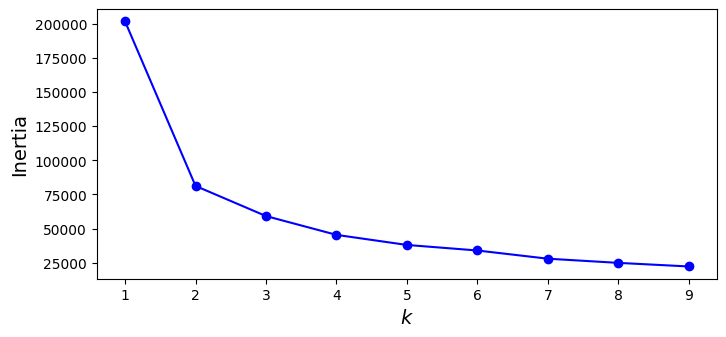

In [ ]:
inertias = [model.inertia_ for model in kmeans_per_k]
plt.figure(figsize=(8, 3.5))
plt.plot(range(1, 10), inertias, "bo-")
plt.xlabel("$k$", fontsize=14)
plt.ylabel("Inertia", fontsize=14)

#plt.axis([1, 8.5, 0, 1300])
plt.show()

In [17]:
silhouette_scores = [silhouette_score(X, model.labels_)
                     for model in kmeans_per_k[1:]]

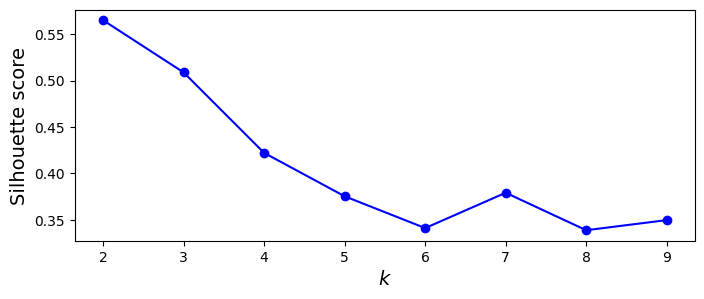

In [18]:
plt.figure(figsize=(8, 3))
plt.plot(range(2, 10), silhouette_scores, "bo-")
plt.xlabel("$k$", fontsize=14)
plt.ylabel("Silhouette score", fontsize=14)
#plt.axis([1.8, 8.5, 0.55, 0.7])
plt.show()

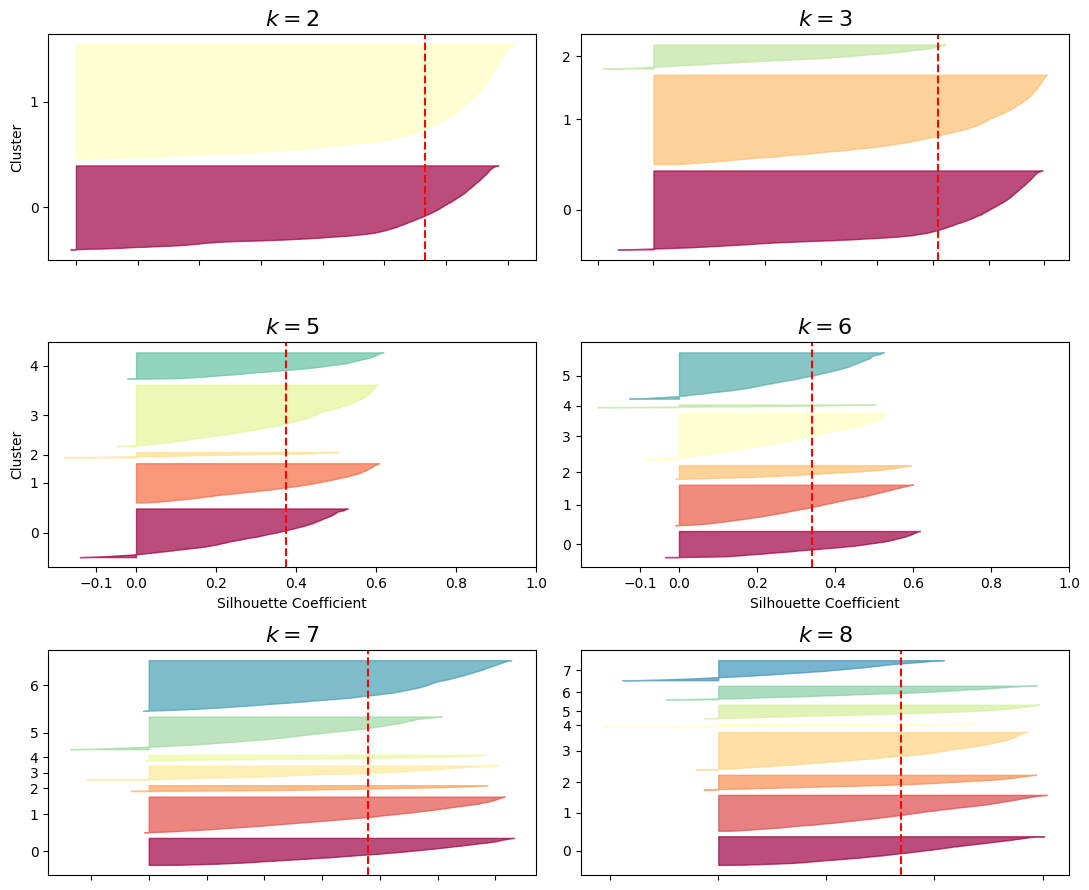

In [21]:
from sklearn.metrics import silhouette_samples
from matplotlib.ticker import FixedLocator, FixedFormatter
import matplotlib as mpl
import numpy as np

plt.figure(figsize=(11, 9))

for i, k in enumerate((2, 3, 5, 6, 7, 8), start=1):
    plt.subplot(3, 2, i)  # i goes from 1 to 4
    y_pred = kmeans_per_k[k - 1].labels_
    silhouette_coefficients = silhouette_samples(X, y_pred)

    padding = len(X) // 30
    pos = padding
    ticks = []
    for j in range(k):
        coeffs = silhouette_coefficients[y_pred == j]
        coeffs.sort()

        color = mpl.cm.Spectral(j / k)
        plt.fill_betweenx(np.arange(pos, pos + len(coeffs)), 0, coeffs,
                          facecolor=color, edgecolor=color, alpha=0.7)
        ticks.append(pos + len(coeffs) // 2)
        pos += len(coeffs) + padding

    plt.gca().yaxis.set_major_locator(FixedLocator(ticks))
    plt.gca().yaxis.set_major_formatter(FixedFormatter(range(k)))
    if i in (1, 3):
        plt.ylabel("Cluster")

    if i in (3, 4):
        plt.gca().set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])
        plt.xlabel("Silhouette Coefficient")
    else:
        plt.tick_params(labelbottom=False)

    plt.axvline(x=silhouette_scores[k - 2], color="red", linestyle="--")
    plt.title(f"$k={k}$", fontsize=16)

plt.tight_layout()
plt.show()


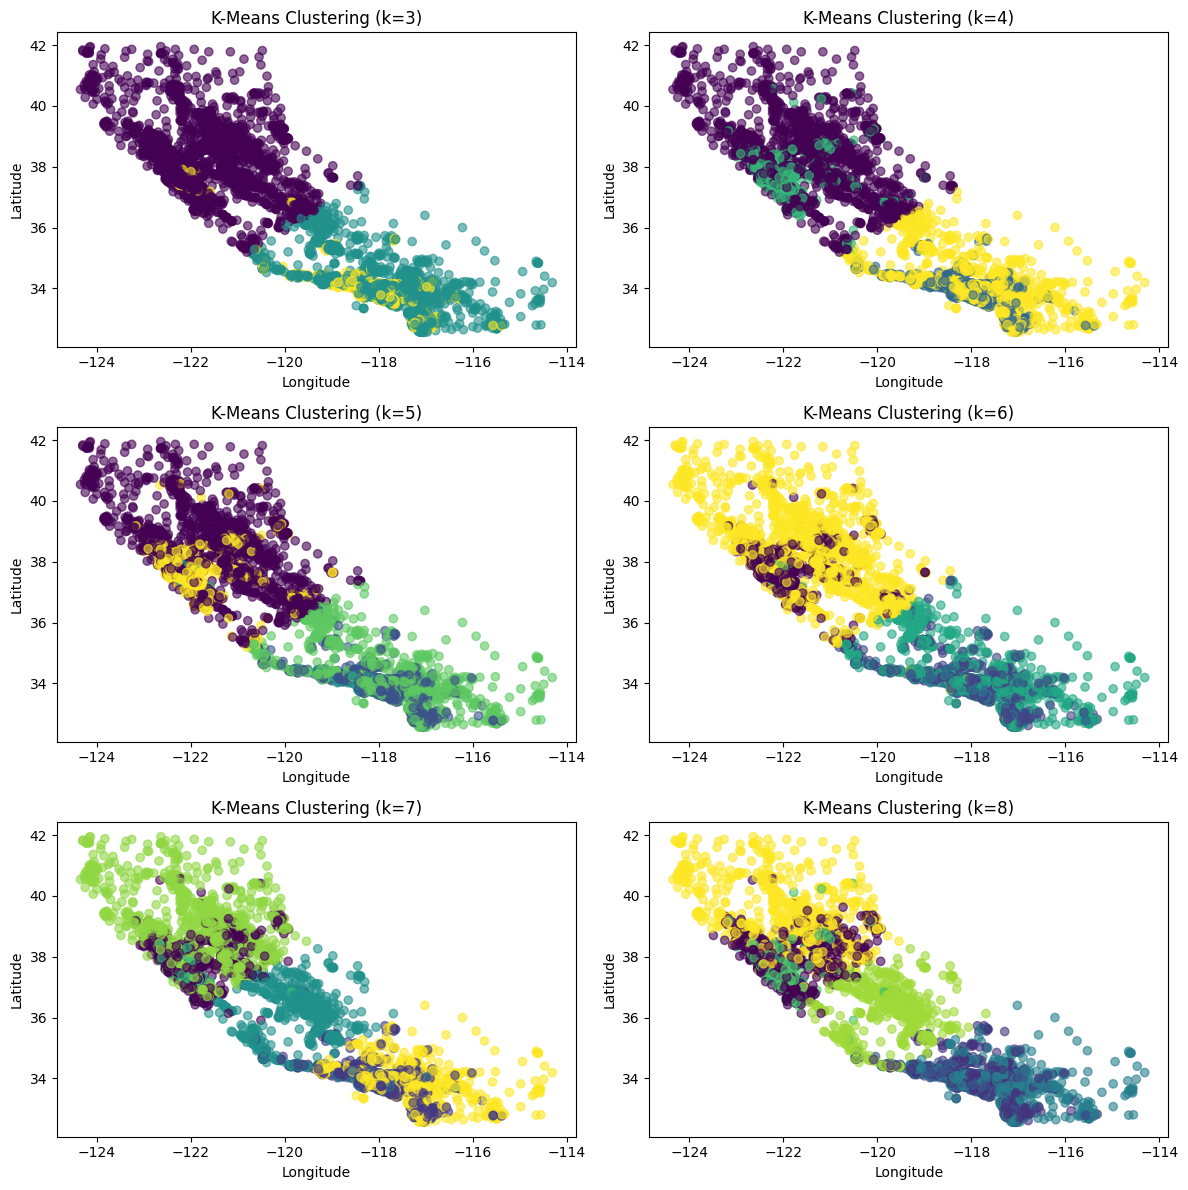

In [34]:
k_values = [3, 4, 5, 6, 7, 8]

plt.figure(figsize=(12, 12))

for i, k in enumerate(k_values, start=1):
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X)
    train_set["cluster"] = kmeans.labels_
    
    plt.subplot(3, 2, i)
    plt.scatter(train_set["longitude"], train_set["latitude"],
                c=train_set["cluster"], cmap="viridis", alpha=0.6)
    plt.title(f"K-Means Clustering (k={k})")
    plt.xlabel("Longitude")
    plt.ylabel("Latitude")

plt.tight_layout()
plt.show()

## Spectral Clustering

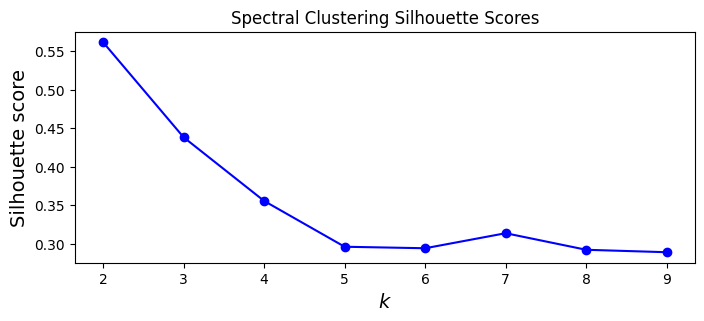

In [40]:
from sklearn.cluster import SpectralClustering


ks = range(2, 10)
silhouette_scores = []

for k in ks:
    spectral = SpectralClustering(n_clusters=k, affinity='nearest_neighbors',
                                  assign_labels='kmeans', random_state=42)
    labels = spectral.fit_predict(X)
    score = silhouette_score(X, labels)
    silhouette_scores.append(score)

plt.figure(figsize=(8, 3))
plt.plot(ks, silhouette_scores, "bo-")
plt.xlabel("$k$", fontsize=14)
plt.ylabel("Silhouette score", fontsize=14)
plt.title("Spectral Clustering Silhouette Scores")
plt.show()

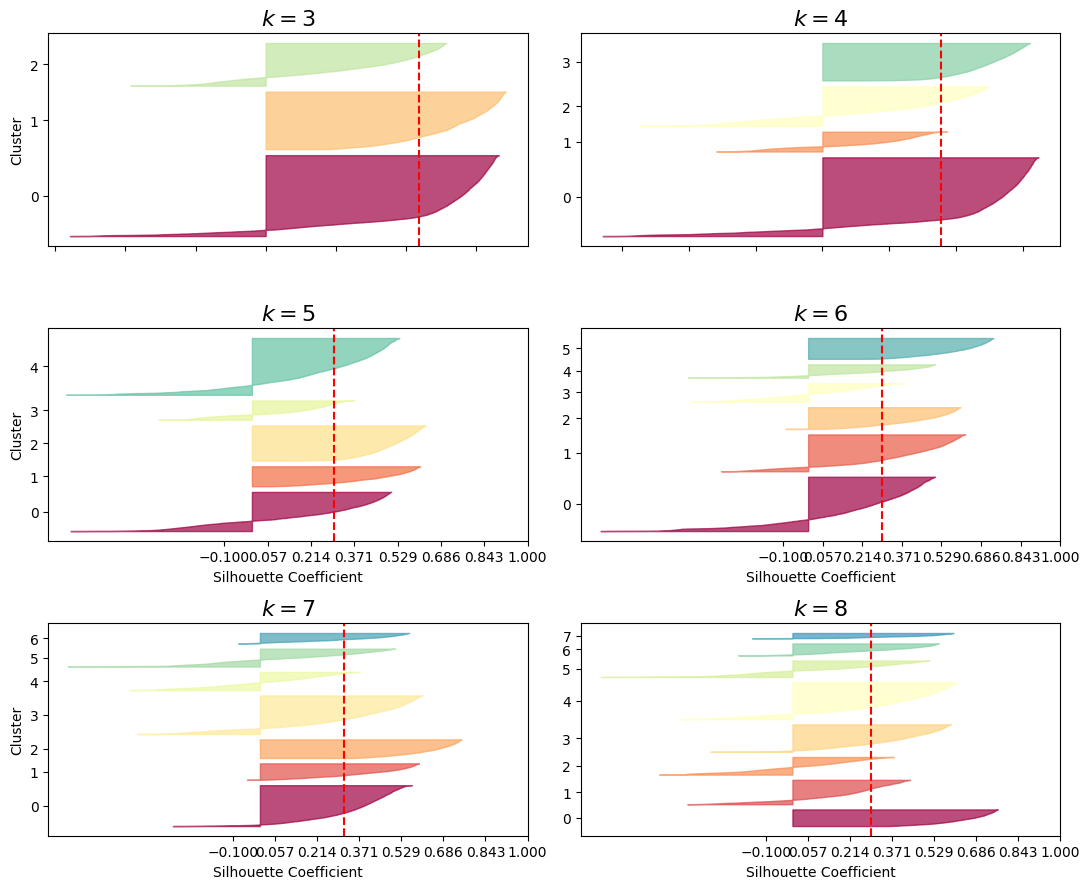

In [44]:
k_values = [3, 4, 5, 6, 7, 8]

spectral_sil_scores = []
spectral_labels_per_k = []

for k in k_values:
    spectral = SpectralClustering(n_clusters=k, affinity='nearest_neighbors',
                                  assign_labels='kmeans', random_state=42)
    labels = spectral.fit_predict(X)
    spectral_labels_per_k.append(labels)
    score = silhouette_score(X, labels)
    spectral_sil_scores.append(score)

plt.figure(figsize=(11, 9))

for i, k in enumerate(k_values, start=1):
    plt.subplot(3, 2, i)
    y_pred = spectral_labels_per_k[i-1]
    silhouette_coefficients = silhouette_samples(X, y_pred)

    padding = len(X) // 30
    pos = padding
    ticks = []

    for j in range(k):
        coeffs = silhouette_coefficients[y_pred == j]
        coeffs.sort()

        color = mpl.cm.Spectral(j / k)
        plt.fill_betweenx(np.arange(pos, pos + len(coeffs)), 0, coeffs,
                          facecolor=color, edgecolor=color, alpha=0.7)
        ticks.append(pos + len(coeffs) // 2)
        pos += len(coeffs) + padding

    plt.gca().yaxis.set_major_locator(FixedLocator(ticks))
    plt.gca().yaxis.set_major_formatter(FixedFormatter(range(k)))
    if i in (1, 3, 5):
        plt.ylabel("Cluster")

    if i in (3, 4, 5, 6):
        plt.gca().set_xticks(np.linspace(-0.1, 1, 8))
        plt.xlabel("Silhouette Coefficient")
    else:
        plt.tick_params(labelbottom=False)

    plt.axvline(x=spectral_sil_scores[i-1], color="red", linestyle="--")
    plt.title(f"$k={k}$", fontsize=16)

plt.tight_layout()

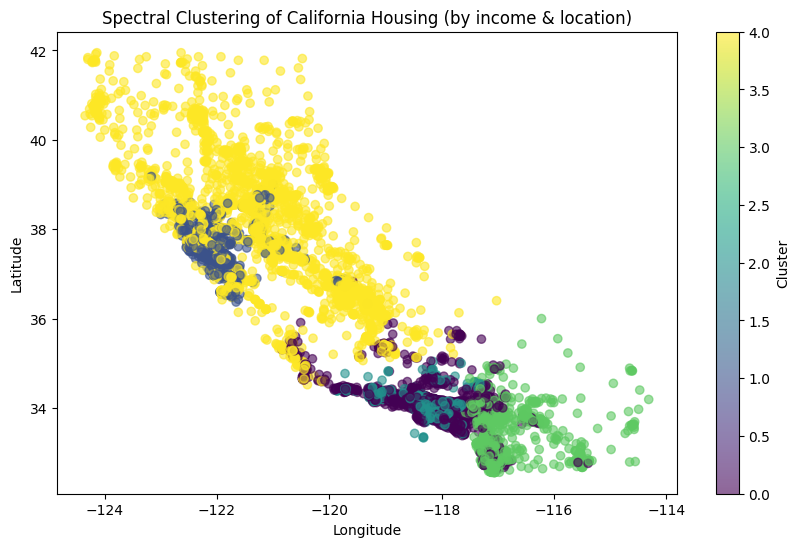

In [ ]:
spectral = SpectralClustering(n_clusters=5, affinity='nearest_neighbors', assign_labels='kmeans', random_state=42)
train_set["spectral_cluster"] = spectral.fit_predict(X)

plt.figure(figsize=(10,6))
plt.scatter(train_set["longitude"], train_set["latitude"],
            c=train_set["spectral_cluster"], cmap="viridis", alpha=0.6)
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.title("Spectral Clustering of California Housing (by income & location)")
plt.colorbar(label="Cluster")
plt.show()

In [33]:
kmeans_score = silhouette_score(X, kmeans.labels_)
spectral_score = silhouette_score(X, spectral.labels_)

print("K-Means Silhouette Score:", kmeans_score)
print("Spectral Silhouette Score:", spectral_score)

K-Means Silhouette Score: 0.3387495138229433
Spectral Silhouette Score: 0.2963507969991275


## Decision Boundaries




In [29]:
def plot_data(X):
    plt.plot(X[:, 0], X[:, 1], 'k.', markersize=2)

def plot_centroids(centroids, weights=None, circle_color='w', cross_color='k'):
    if weights is not None:
        centroids = centroids[weights > weights.max() / 10]
    plt.scatter(centroids[:, 0], centroids[:, 1],
                marker='o', s=35, linewidths=8,
                color=circle_color, zorder=10, alpha=0.9)
    plt.scatter(centroids[:, 0], centroids[:, 1],
                marker='x', s=2, linewidths=12,
                color=cross_color, zorder=11, alpha=1)

def plot_decision_boundaries(clusterer, X, resolution=1000, show_centroids=True,
                             show_xlabels=True, show_ylabels=True):
    mins = X.min(axis=0) - 0.1
    maxs = X.max(axis=0) + 0.1
    xx, yy = np.meshgrid(np.linspace(mins[0], maxs[0], resolution),
                         np.linspace(mins[1], maxs[1], resolution))
    Z = clusterer.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)

    plt.contourf(Z, extent=(mins[0], maxs[0], mins[1], maxs[1]),
                cmap="Pastel2")
    plt.contour(Z, extent=(mins[0], maxs[0], mins[1], maxs[1]),
                linewidths=1, colors='k')
    plot_data(X)
    if show_centroids:
        plot_centroids(clusterer.cluster_centers_)

    if show_xlabels:
        plt.xlabel("$x_1$", fontsize=14)
    else:
        plt.tick_params(labelbottom=False)
    if show_ylabels:
        plt.ylabel("$x_2$", fontsize=14, rotation=0)
    else:
        plt.tick_params(labelleft=False)

In [30]:
plt.figure(figsize=(8, 4))
plot_decision_boundaries(kmeans, X)
plt.show()

C:\Users\samue\AppData\Local\Temp\ipykernel_38808\3129565975.py:18: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  xx, yy = np.meshgrid(np.linspace(mins[0], maxs[0], resolution),
C:\Users\samue\AppData\Local\Temp\ipykernel_38808\3129565975.py:19: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  np.linspace(mins[1], maxs[1], resolution))
c:\Users\samue\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but KMeans was fitted with feature names
  warnings.warn(


ValueError: X has 2 features, but KMeans is expecting 3 features as input.

<Figure size 800x400 with 0 Axes>